# Melanoma Detection Exercise - Solution Workbook

#### A multiclass classification model using a custom Convolutional Neural Network (CNN) in TensorFlow

## 1. Problem Statement
To build a **CNN based model** which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset for this exercise consists of images of malignant and benign oncological diseases, which were formed from the **International Skin Imaging Collaboration (ISIC)**. All images were sorted according to the classification taken with ISIC.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

**Our Approach**

We will follow the below steps while executing this case study:

1. Import & Understand Data
2. Create Datasets
3. Visualise Dataset
4. Preprocess, Build & Train Model
5. Augment Dataset & Remodel
6. Handle Class Imbalance & Remodel
7. Make Predictions
8. Conclusion

## 1. Import & Understand Data

### 1.1 Setup Important Libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### 1.2 Setup the Datasets

In [3]:
## Mount the google drive for accessing dataset frm Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [4]:
# Change directory to the folder which contains the zipped dataset
%ls
%cd /content/gdrive/MyDrive/DS Datasets
%pwd

gdrive/  sample_data/
/content/gdrive/MyDrive/DS Datasets


'/content/gdrive/MyDrive/DS Datasets'

In [5]:
# Unzip the ISIC Dataset if not done already
!unzip CNN_assignment.zip

Archive:  CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The I

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Define the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
# Review the number of images in Train & Test folders
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## 2. Create the Datasets

Let's load these images off disk using the helpful image_dataset_from_directory utility in tf.keras.preprocessing library

In [8]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write the train dataset
## Resize images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write the validation dataset
## Use the same seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# The class names are found in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Visualize the Datasets
#### Create code to visualize one instance of all the nine classes present in the dataset

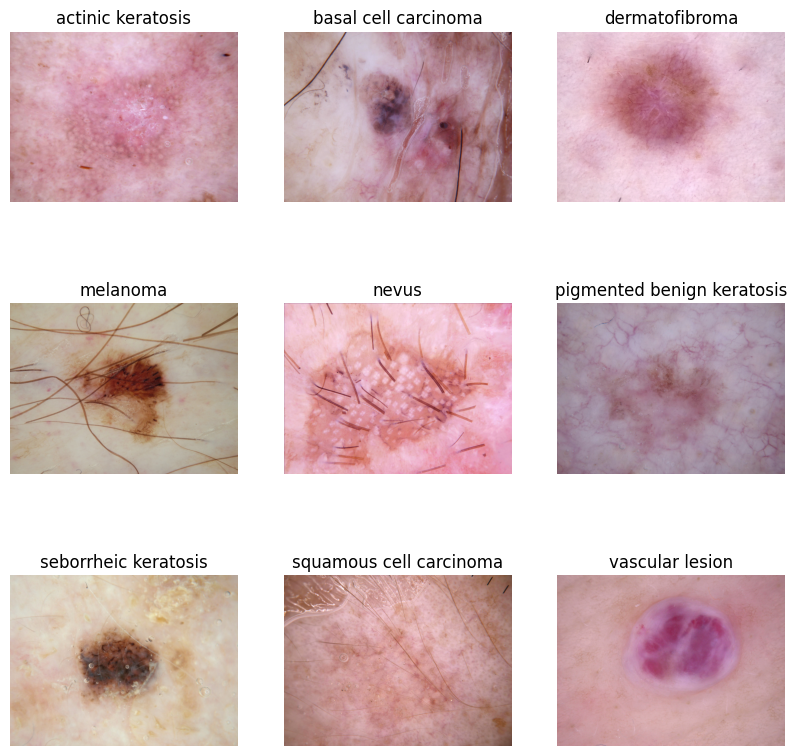

In [12]:
import matplotlib.pyplot as plt
from skimage import io
import random

# Use training data to visualize
plt.figure(figsize=(10, 10))
i = 0
for class_path in class_names:
  # Walk-thru' each of the class directories
  image_path = os.path.join(data_dir_train, class_path, '*')
  images = tf.io.gfile.glob(image_path)
  # Pick a randomly chosen image from the class_path
  rand_index = random.randint(0, len(images))
  image = io.imread(images[rand_index])
  # Plot the image in a 3X3 subplot
  ax = plt.subplot(3, 3, i + 1)
  plt.title(class_path)
  plt.axis("off")
  plt.imshow(image)
  i+=1

#### **Configure the Datasets for Performance**

Enable buffered prefetching, so that we can yield data from disk without having I/O getting blocked. We will enable two important methods for loading data:

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Preprocess, Build & Train Model

### 4.1 Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset.
#### Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range which is not ideal for a neural network. Hence, it is good to standardize values to be in the `[0, 1]`

In [14]:
# We would build a sequential model here with each layer having an input tensor and an output tensor

num_classes = len(class_names)

model = Sequential([
  # Preprocess the Dataset by scaling the values
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 2D Convolution Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  # Downsample the input along its spatial dimension (height & width) by taking the maximum value over an input window (of size defined by pool_size ) for each channel of the input
  layers.MaxPooling2D(),

  # 2D Convolution Layer - Sliding over the feature map and extract tiles of a specified size
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  # Downsample the input along its spatial dimension (height & width)
  layers.MaxPooling2D(),

  # 2D Convolution Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  # Downsample the input - decreasing the size of input of upcoming layers, works against overfitting
  layers.MaxPooling2D(),

  # Flattening to convert into 1D feature vector creating a single long feature vector
  layers.Flatten(),

  # Dense (fully connected) layer - hidden layer where every node is connected to every node in previous layer
  layers.Dense(128, activation='relu'),

  # Output layer with 'softmax' activation
  layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 4.2 Compile the Model
Choose an appropirate optimiser and loss function for model training

In [15]:
# Choose 'adam' optimiser and 'categorical crossentropy' loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### 4.3 Train the model

In [17]:
# Train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.2355 - loss: 2.2856 - val_accuracy: 0.3221 - val_loss: 1.8702
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3140 - loss: 1.8584 - val_accuracy: 0.3870 - val_loss: 1.6933
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4408 - loss: 1.6196 - val_accuracy: 0.4966 - val_loss: 1.5253
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5057 - loss: 1.4362 - val_accuracy: 0.5257 - val_loss: 1.4608
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5395 - loss: 1.3058 - val_accuracy: 0.5213 - val_loss: 1.3869
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5484 - loss: 1.2610 - val_accuracy: 0.4609 - val_loss: 1.4361
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5571 - loss: 1.2373 - val_accuracy: 0.5145 - val_loss: 1.4294
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5943 - loss: 1.1465 - val_accuracy: 0.5302 -

### 4.4 Visualize The Training Results

#### Plot the Accuracy and Loss metrics over multiple epochs to understand the trend of the metrices

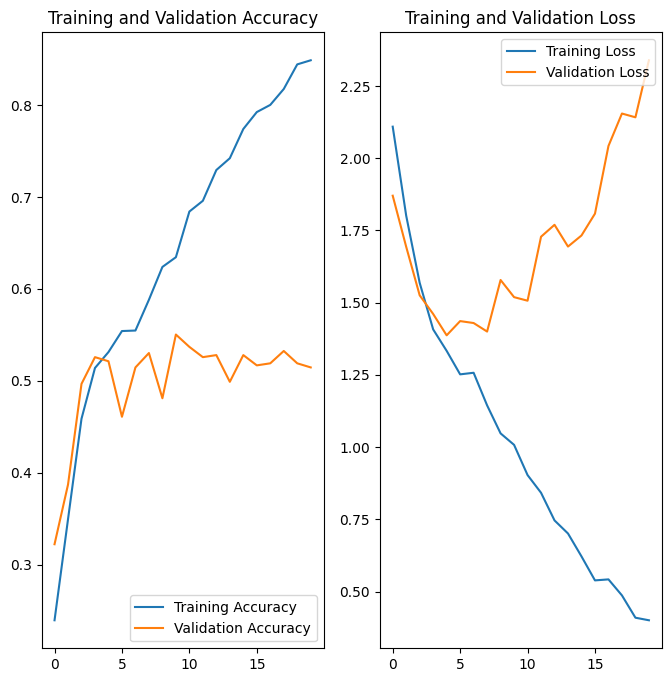

In [18]:
# Extract the accouracy and loss results from Model result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot the Accuracy trend
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the Loss trend
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings**

1] It can be seen that there is a significant difference between Traning and Validation Accuracy. The Validation Accuracy tapers off after reaching a max of 55% while Training Accuracy keeps on increasing till 85%. This indicates that the model kept memorising training data indicating definite symptoms of overfitting.

2] The validation accuracy the model has achieved is about 55 % which is not high enough to use it in practical applications.

#### **Suggestions**
We can take some measures to reduce overfitting while improving validation accuracy. Let's next apply techniques like Data Augmentation and Dropout to observe the model behaviour

## 5. Augment Dataset & Remodel

#### Generate additional training data from existing samples through data augmentation

#### **Data Augmentation Strategy**

Overfitting is caused by the presence of a small number of training samples. The network learns those samples closely such that generalisation becomes difficult. Data augmentation works on generating additional training data from existing samples by augmenting them using random transformations that generate real-like images. This equips the model to more varieties of the data and helps in generalising better.

We will implement data augmentation using the Keras preprocessing layers for following types of transformations:
* tf.keras.layers.RandomFlip
* tf.keras.layers.RandomRotation
* tf.keras.layers.RandomZoom

These will be included inside the model like another layer.

### 5.1 Create Data Augmentation Layer

In [19]:
# Create data augmentation layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

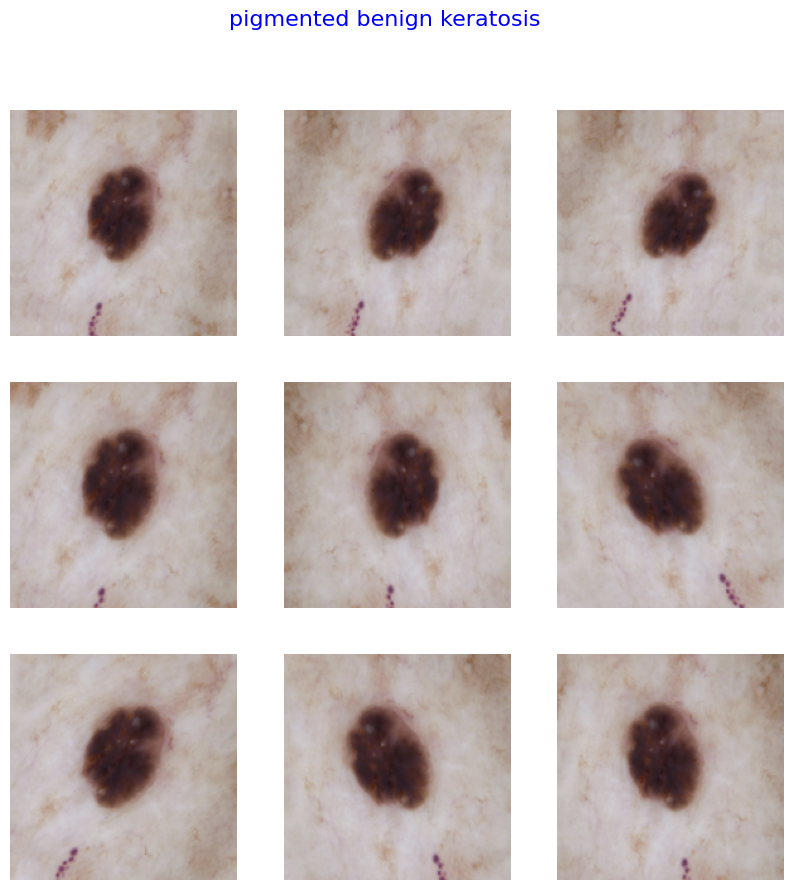

In [20]:
# Visualize how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
# Pick an image from training dataset randomly
images, labels = next(iter(train_ds))
rand_index = random.randint(0, len(images))
image = images[rand_index]
image = tf.cast(tf.expand_dims(image, 0), tf.float32) #Expand the shape of the impage to comply with preprocessing layer requirements

# Visualise the augmented images for the selected image by applying repeatedly on same image
for i in range(9):
  augmented_images = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8"))
  plt.suptitle(class_names[labels[rand_index]], color='blue', fontsize=16)
  plt.axis("off")

### 5.2 Create Model with Augmentation Layer


In [21]:
# Use Dropout layer since there is an evidence of overfitting in the model
# A dropout layer randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.
# Use a fractional number of 0.2 as its input value which means dropping out 20% of the output units randomly from the applied layer.

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Add the Dropout Layer
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])

### 5.3 Compile the Model

In [22]:
## Compile/ build the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.build(input_shape=(batch_size, img_height, img_width, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 180, 180, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 90, 90, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 90, 90, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 45, 45, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 45, 45, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 30976)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (32, 9)                     │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### 5.4 Train the Model

In [23]:
## Train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2078 - loss: 2.1407 - val_accuracy: 0.3400 - val_loss: 1.8224
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3454 - loss: 1.7927 - val_accuracy: 0.3758 - val_loss: 1.6738
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4139 - loss: 1.6585 - val_accuracy: 0.4832 - val_loss: 1.4994
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5076 - loss: 1.4027 - val_accuracy: 0.5213 - val_loss: 1.4015
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5348 - loss: 1.3291 - val_accuracy: 0.5503 - val_loss: 1.3606
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5098 - loss: 1.3604 - val_accuracy: 0.5347 - val_loss: 1.3321
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5427 - loss: 1.2671 - val_accuracy: 0.5391 - val_loss: 1.3743
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5688 - loss: 1.2033 - val_accuracy: 0.5459 - v

### 5.5 Visualise the Results

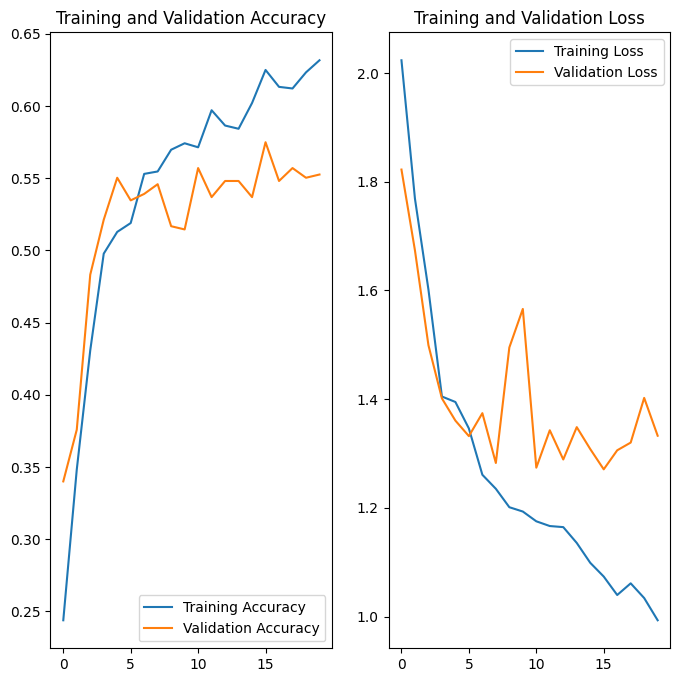

In [24]:
# Extract the accouracy and loss results from Model result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot the Accuracy trend
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the Loss trend
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings**

After looking at the model outcome, it appears that the model overfitting issue is largely resolved with both Training and Validation accuracies increasing simultaneously as the Epochs execute. Training accuracy tapers off at around 63% accuracy range while Validation accuracy plateaues at about 55% which is not too far from the Training accuracy.

While this is good from overfitting issue perspective, but not being able to reach higher accuracy levels indicating high bias (i.e. underfitting) in the network, is the next concern of this model.

**Suggestions**

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check let's examine what is the distribution of classes in the data.

## 6. Handle Class Imbalance & Remodel

#### Find the distribution of classes in the training dataset.

### 6.1 Examine Class Distribution in Datasets

In [25]:
## Determine the number of images in Training dataset by Class

image_dict = {}
for class_path in class_names:
  # Walk-thru' each of the class directories
  image_path = pathlib.Path(os.path.join(data_dir_train, class_path, ''))
  image_count = len(list(image_path.glob('*.jpg')))
  # Store the counts and percentages in a dict
  image_dict[class_path] = [image_count, round(image_count/image_count_train*100, 1)]

# Create a dataframe from the dict
image_df = pd.DataFrame.from_dict(image_dict, orient='index', columns=["Count", "Percent"])
image_df = image_df.reset_index().rename(columns={'index': 'Class'})
image_df

,Class,Count,Percent
0,actinic keratosis,114,5.1
1,basal cell carcinoma,376,16.8
2,dermatofibroma,95,4.2
3,melanoma,438,19.6
4,nevus,357,15.9
5,pigmented benign keratosis,462,20.6
6,seborrheic keratosis,77,3.4
7,squamous cell carcinoma,181,8.1
8,vascular lesion,139,6.2


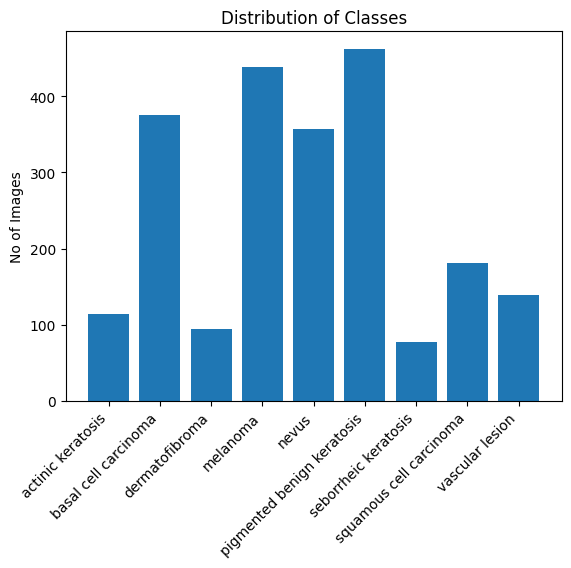

In [26]:
# Plot the Number of Images by Class in a bar diagram
plt.bar(image_df['Class'], image_df['Count'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("No of Images")
plt.title("Distribution of Classes")
plt.show()

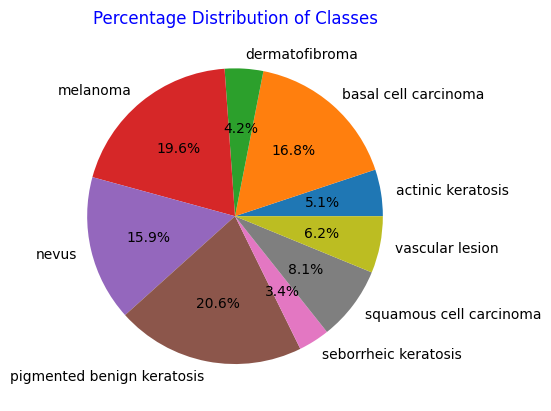

In [27]:
# Also plot the % distribution of Images by Class in a pie chart
plt.pie(image_df['Percent'], labels=image_df['Class'], autopct='%1.1f%%')
plt.title("Percentage Distribution of Classes", color='blue')
plt.show()

#### **Findings**

As we can see from the above diagrams, the images in the Dataset are not proportionately distributed among all classes.

* `Seborrheic Keratosis` class has the least number of samples with a count of 77 which is only 3.4% of the dataset. For a 9 class dataset, it should have ~11% proportion if all classes had equal distribution of images

* The classes that dominate the data in terms proportionate number of samples are `Pigmented Benign Keratosis`, `Melanoma` and `Basal Cell Carcinoma` having 20.6%, 19.6% and 16.8% proportions respectively

#### **Suggestions**

Let's rectify the class imbalance by adding more samples to each class using `Augmentor` technique so that none of the classes have very few samples

### 6.2 Rectify the Class Imbalance

In [28]:
## Use the python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/)
## to add more samples across all classes
## Install Augmentor first

!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
import glob
from glob import glob

In [30]:
# Store the class-wise image maps in the original dataset before adding the augmented images

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/DS Datasets/Skin cance...,actinic keratosis
1,/content/gdrive/MyDrive/DS Datasets/Skin cance...,actinic keratosis
2,/content/gdrive/MyDrive/DS Datasets/Skin cance...,actinic keratosis
3,/content/gdrive/MyDrive/DS Datasets/Skin cance...,actinic keratosis
4,/content/gdrive/MyDrive/DS Datasets/Skin cance...,actinic keratosis


In [31]:
# For each class, add 500 additional samples using left & right rotation to augment existing data
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i, output_directory = str(path_to_training_dataset) + "/" + i +'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FE1B8CF310>: 100%|██████████| 500/500 [00:26<00:00, 18.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FE167133A0>: 100%|██████████| 500/500 [00:25<00:00, 19.49 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FE1B9D0190>: 100%|██████████| 500/500 [00:21<00:00, 23.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x77FE16727E50>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x77FE1B92EB00>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FE1B8CF340>: 100%|██████████| 500/500 [00:21<00:00, 22.89 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x77FE1BBAEAD0>: 100%|██████████| 500/500 [00:43<00:00, 11.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FE1BA0EC50>: 100%|██████████| 500/500 [00:20<00:00, 24.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/DS Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FE1B92EB00>: 100%|██████████| 500/500 [00:20<00:00, 24.63 Samples/s]


Augmentor stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
# Compute the image count of addiitional images in */output folders which should be 500 X 9 (classes) = 4500
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [33]:
# Define the path to all new (augmented) images
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# Define list of labels for corresponding new images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# Build a dataframe containing new image details and combine with the original dataframe
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
augmented_df = pd.concat([original_df, new_df])
augmented_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain better class balance. We can add more images as we want to improve training process further. Let's now train the model on the data created using Augmentor

### 6.3 Re-create the Datasets

In [34]:
# First recreate the training dataset
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [35]:
# Next, recreate the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### 6.4 Create The Model

In [48]:
## Define the model including the normalisation and data augmentation

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### 6.5 Compile the Model

In [49]:
## Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Create a ModelCheckpoint callback to save a model or weights (in a checkpoint file) at some interval for later usage
checkpoint = ModelCheckpoint("model.final.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Create a EarlyStopping callback to stop training when a monitored metric has stopped improving
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [50]:
# Do a model build before training to review and confirm model summary
model.build(input_shape=(batch_size, img_height, img_width, 3))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 180, 180, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 90, 90, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 90, 90, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 45, 45, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 45, 45, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (32, 30976)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 128)                   │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 9)                     │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### 6.6 Train the Model

In [51]:
## Use 50 epochs and the callbacks to train the model

epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.2697 - loss: 1.9373
Epoch 1: val_accuracy improved from -inf to 0.38233, saving model to model.final.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 254ms/step - accuracy: 0.2700 - loss: 1.9363 - val_accuracy: 0.3823 - val_loss: 1.6064
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.4333 - loss: 1.4864
Epoch 2: val_accuracy improved from 0.38233 to 0.44395, saving model to model.final.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 246ms/step - accuracy: 0.4333 - loss: 1.4864 - val_accuracy: 0.4439 - val_loss: 1.4356
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4724 - loss: 1.3820
Epoch 3: val_accuracy improved from 0.44395 to 0.45509, saving model to model.final.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 265ms/step - accuracy: 0.4724 - loss: 1.3819 - val_accuracy: 0.4551 - val_loss: 1.4228
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5100 - loss: 1.2912
Epoch 4: val_accuracy

### 6.7 Visualise the Model Results

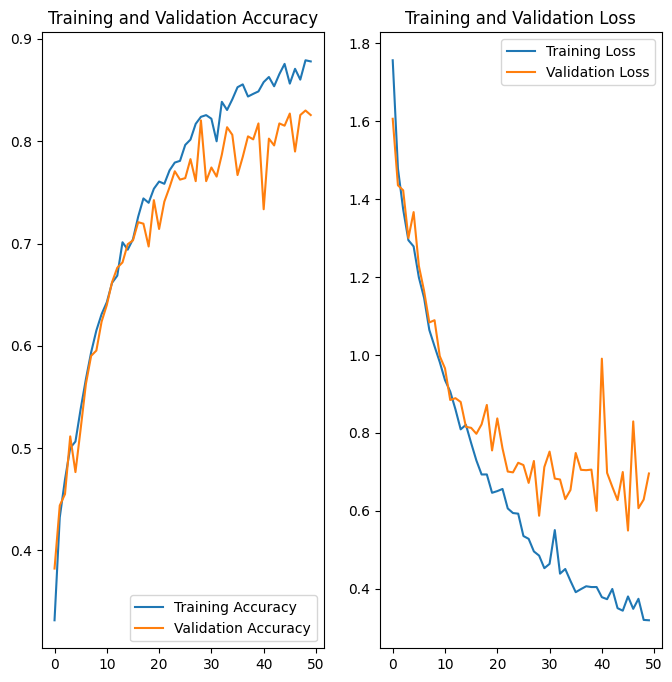

In [52]:
# Extract the accouracy and loss results from Model result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot the Accuracy trend
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the Loss trend
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings**  

1. Accuracy level for both training and validation processes have gone up much higher with Training Accuracy upto 88% while Validation Accuracy raising to 83%. This shows that the augmented images helped significantly in reducing bias of the model

2. The overfitting issue has been resolved largely with accuracy trend of validation process closely following that of training process

Overall we now have a much better model which is capable of predicting melanoma with better accuracy and consistency

## 7. Make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Actual Class squamous cell carcinoma
Predictive Class squamous cell carcinoma


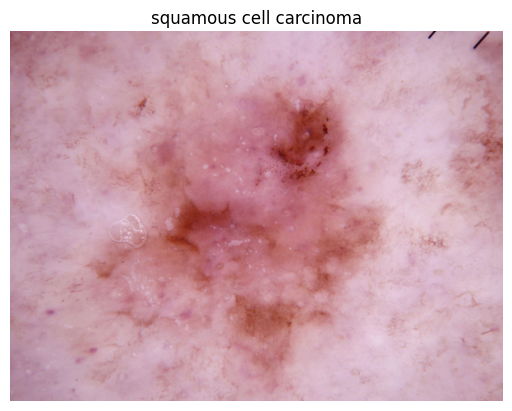

In [53]:
# Pick an image randomly from test dataset and predict its class
class_name = class_names[np.random.randint(len(class_names))]
test_image_path = os.path.join(data_dir_test, class_name, '*')

# Load the images
images = tf.io.gfile.glob(test_image_path)

# Pick a randomly chosen image from the class_path
rand_index = np.random.randint(len(images))
image = io.imread(images[rand_index])

# Show the image
plt.title(class_name)
plt.axis("off")
plt.imshow(image)

# Resize the image
image = tf.image.resize(image, (img_height, img_width))
# Convert to numpy array
image = tf.keras.utils.img_to_array(image)
# Expand the dimensions (create a batch)
image = tf.cast(tf.expand_dims(image, axis=0), tf.float32)

# Make predictions
pred = model.predict(image)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_name +'\n'+ "Predictive Class "+pred_class )

## 8. Conclusion

A CNN model is built using `keras` with three convolutional layers and one dense intermediate layer to analyse the images of various cancer types to particularly detect melanoma among patients.

The basic model with **less number of images had overfitting issue** manifested through a significant gap between training and validation accuracies.

Subsequently **data aumentation technique** was used to increase the number of images though random transformation. This helped in addressing the overfitting issue, but it **brought down the accuracy** to near 55%.

Later the class-wise **data imbalance issue** was addressed by augmenting each class with additional 500 images. This helped improving the accuracies above 80% while keeping the overfitting issue in check.

So we have a very good CNN model at the end which is able to accurately predict various cancer types including melanoma based on the images.